<a href="https://colab.research.google.com/github/BohdanBuhrii/enemy-detection/blob/main/data-generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
dataset_path = '/content/drive/MyDrive/datasets/DOTA_cropped/'
objects_path = '/content/drive/MyDrive/objects/'
output_path = '/content/drive/MyDrive/datasets/vehicles/'
image_size = 1024

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pwd

/content


In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from time import time

from PIL import Image, ImageDraw, ImageOps
from sklearn.model_selection import train_test_split

np.random.seed(12)

In [9]:

def read_image(path):
    return Image.fromarray((plt.imread(path)*255).astype(np.uint8))

## Explore images generation

In [10]:
path_to_backgrounds = dataset_path + 'images_p1/'
background = read_image(path_to_backgrounds + 'P0076.png')
background.size

(719, 635)

In [11]:
tank = read_image(objects_path + 'tank-t72b3.png')
tank.size

(319, 133)

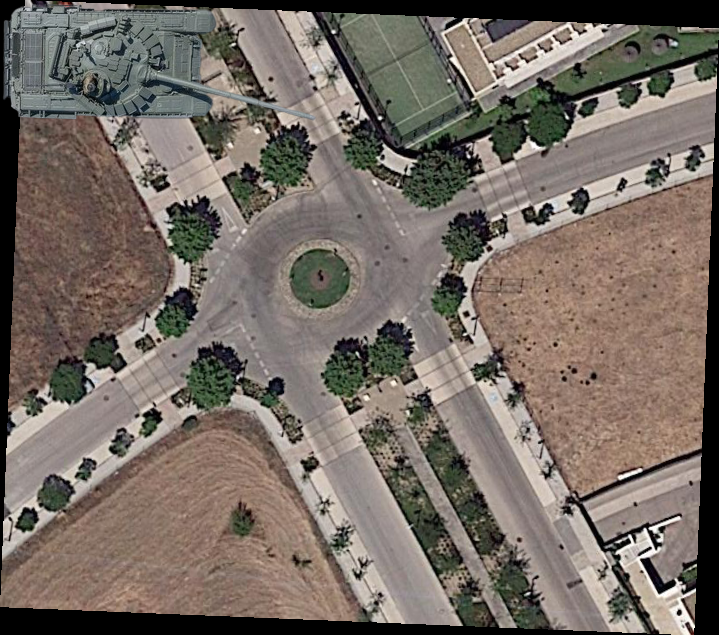

In [12]:
sample = background.copy()
sample.paste(tank, (0,0), tank)
sample

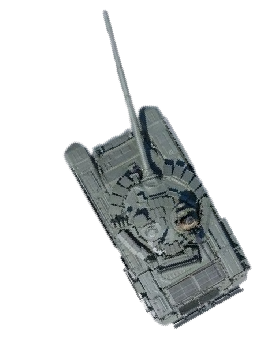

In [13]:
tank_r = tank.rotate(120, expand=True)
tank_r

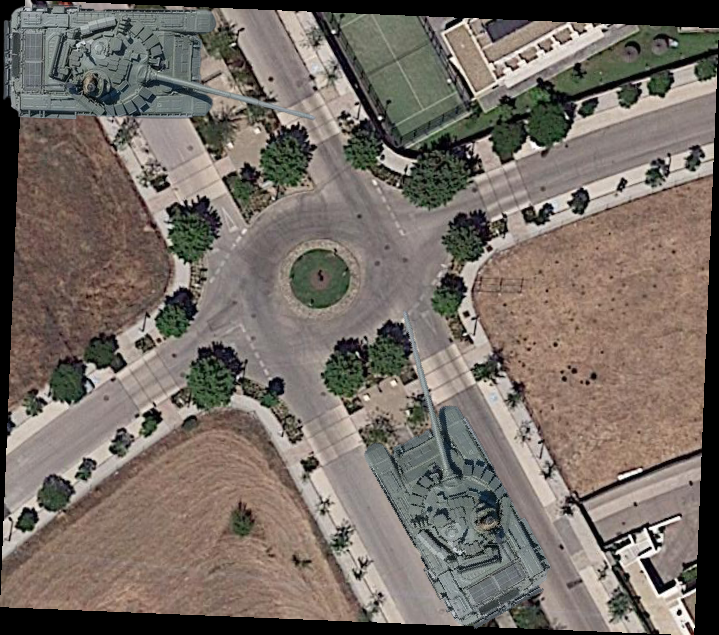

In [14]:
sample.paste(tank_r, (300,300), tank_r)
sample

In [15]:
def crop(img, new_width=image_size, new_height=image_size):
    width, height = img.size

    new_width = min(new_width, width)
    new_height = min(new_height, height)

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    return img.crop((left, top, right, bottom))

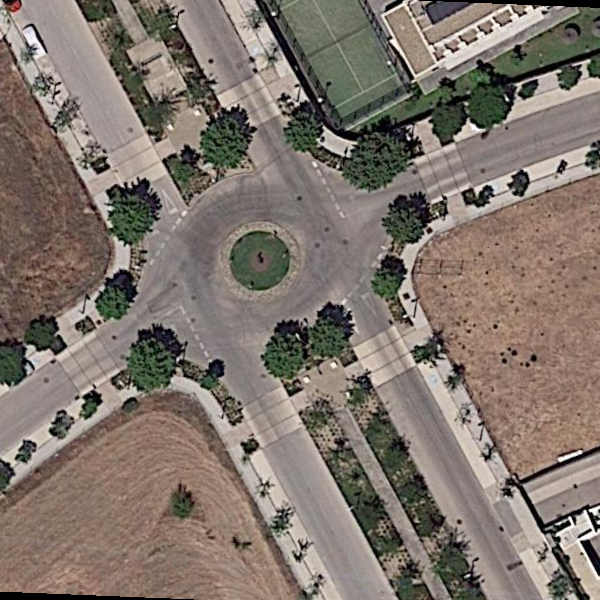

In [16]:
background = crop(background, 600, 600)
background

In [17]:
def resize(image, target_width):
    target_height = int(image.size[1]*target_width/image.size[0])

    return image.resize((target_width,target_height))

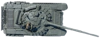

In [18]:
resize(tank, 100)

In [19]:
v_list = os.listdir(objects_path)
v_list

['tank-t72b3.png',
 'mlrs-9k58-smerch.png',
 'ifv-kurganets-25.png',
 'ifv-deryvatsia-pvo.png',
 'ifv-btr-82a.png',
 'ifv-bmp-3.png',
 'ifv-bmp-2m.png']

In [20]:
classes = ['ifv', 'mlrs', 'tank']

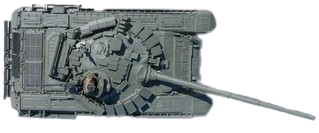

In [21]:
vehicles = [read_image(objects_path + v) for v in v_list]
vehicles[0]

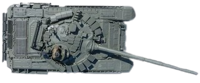

In [22]:
resize(vehicles[0], 200)

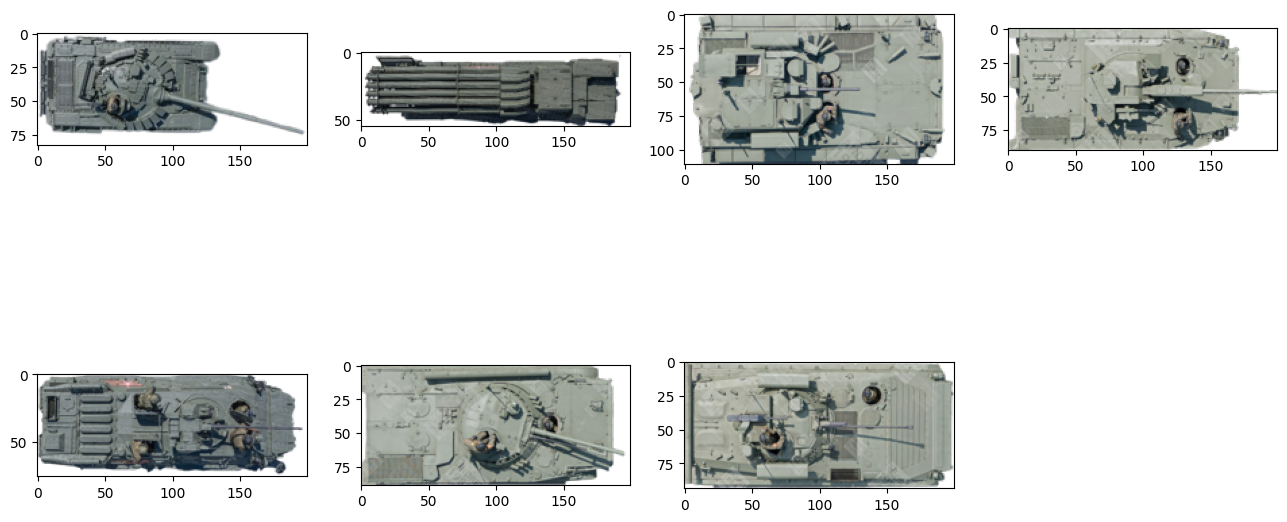

In [23]:
plt.figure(figsize=(16, 8))

for i in range(0, 7):
    plt.subplot(2, 4, i + 1)
    plt.imshow(resize(vehicles[i], 200))

plt.show()

In [24]:
image = background.copy()
draw = ImageDraw.Draw(image)
draw.rectangle((200, 200, 600, 350), outline='#4CFF52', width=3)
image

In [25]:
#TODO preserve real-world ratio between objects

objects = [(resize(v, 60), v_list[i].split('-')[0]) for i, v in enumerate(vehicles)]
objects

[(<PIL.Image.Image image mode=RGBA size=60x25 at 0x7F5F987F6DF0>, 'tank'),
 (<PIL.Image.Image image mode=RGBA size=60x16 at 0x7F5F98D88EB0>, 'mlrs'),
 (<PIL.Image.Image image mode=RGBA size=60x33 at 0x7F5FC155DDF0>, 'ifv'),
 (<PIL.Image.Image image mode=RGBA size=60x27 at 0x7F5FC155DDC0>, 'ifv'),
 (<PIL.Image.Image image mode=RGBA size=60x22 at 0x7F5F944FE3A0>, 'ifv'),
 (<PIL.Image.Image image mode=RGBA size=60x26 at 0x7F5F988070D0>, 'ifv'),
 (<PIL.Image.Image image mode=RGBA size=60x28 at 0x7F5F98807CA0>, 'ifv')]

In [28]:
def put_objects(background, n_min=1, n_max=10, objects=objects):
    base = background.copy()
    n = np.random.randint(n_min, n_max+1)
    
    bboxes = []
    for i in range(n):
        obj, obj_type = objects[np.random.randint(len(objects))]
        int_type = classes.index(obj_type)
        
        obj = obj.rotate(np.random.randint(360), expand=True)
        #x, y = np.random.randint(background.size[0]) - obj.size[0]//2, np.random.randint(background.size[1]) - obj.size[1]//2

        # center of an object
        x, y = np.random.rand(2)
        
        # class x y width height (all normalized)
        bboxes.append((int_type, x, y, obj.size[0]/background.size[0], obj.size[1]/background.size[1]))
        
        # paste by top upper corner
        base.paste(obj, (int(x*background.size[0] - obj.size[0]//2), int(y*background.size[1] - obj.size[1]//2)), obj)
    
    return base, bboxes
        

In [29]:
base, bboxes = put_objects(background)
print(bboxes)
base

[(0, 0.28958678353055356, 0.7331259776126706, 0.11, 0.085), (0, 0.3346475291060558, 0.9780580790165189, 0.07666666666666666, 0.10666666666666667), (0, 0.17284218793716766, 0.12160380054272146, 0.10666666666666667, 0.09666666666666666), (0, 0.608258056645331, 0.7894264757270973, 0.10666666666666667, 0.056666666666666664), (0, 0.26857577981499503, 0.30423439606465597, 0.11666666666666667, 0.09166666666666666), (0, 0.4631488697273459, 0.37372314882391533, 0.10333333333333333, 0.051666666666666666), (1, 0.03516826147080476, 0.08427266973184566, 0.10333333333333333, 0.06), (0, 0.6361999938328675, 0.027907788861532556, 0.08666666666666667, 0.11), (0, 0.2208525208288855, 0.055019993340200135, 0.08333333333333333, 0.11), (0, 0.04858846643868464, 0.5713248908781755, 0.06333333333333334, 0.10833333333333334)]


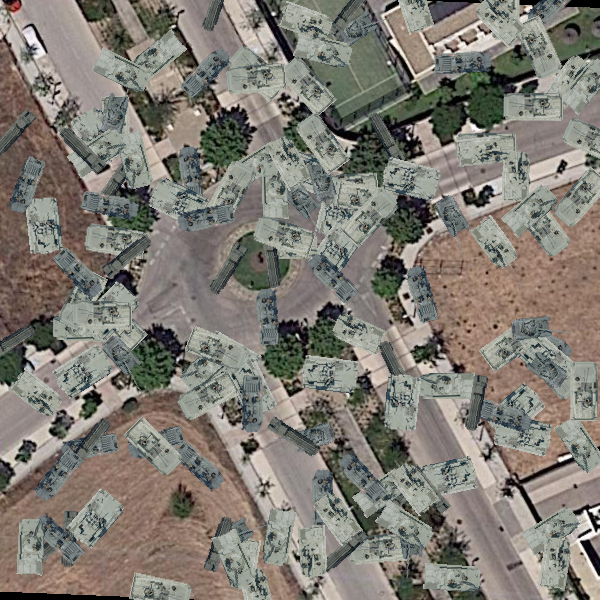

In [30]:
put_objects(background, 100, 200)[0]

In [33]:
def plot_boxes(image, boxes, outline='#4CFF52', width=3):
    image = image.copy()
    draw = ImageDraw.Draw(image)
    
    for b in boxes:
        x, y, w, h = b[1:]
        
        x *= image.size[0]
        y *= image.size[1]

        w *= image.size[0]
        h *= image.size[1]

        draw.rectangle((x - w//2, y - h//2, x + w//2, y + h//2), outline=outline, width=width)
        
    return image

In [34]:
plot_boxes(base, bboxes)

In [35]:
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [36]:
def generate_data(input_images, output_dir, generate_objects=put_objects, need_crop=False):
    output_imgs = output_dir + 'images/'
    output_lbls = output_dir + 'labels/'
    
    if not os.path.exists(output_imgs):
        os.makedirs(output_imgs)
    if not os.path.exists(output_lbls):
        os.makedirs(output_lbls)
    
    progress_step = len(input_images)

    for img_path in log_progress(input_images, every=1):
    
        img_name = img_path.split('/')[-1]
        img = read_image(img_path)
        
        if need_crop:
            img = crop(img, image_size, image_size)
        
        base, boxes = generate_objects(img, 1, 15)

        base.save(output_imgs + img_name)

        # np.savetxt(output_lbls + img_name[:-4] + '.txt', transform_boxes(boxes, 1024))
        np.savetxt(output_lbls + img_name[:-4] + '.txt', boxes)

In [37]:
all_images = []
for root, _, filenames in os.walk(dataset_path):
    if filenames:
        all_images += [os.path.join(root, filename) for filename in filenames]

# split data
train_input, val_input = train_test_split(all_images, test_size=0.2, random_state=12)
val_input, test_input =  train_test_split(val_input, test_size=0.2, random_state=12)

print(len(train_input), len(val_input), len(test_input))

1128 226 57


## Generate images



In [38]:
output_prefix = output_path + '1024/' + str(round(time())) + '/'
print(output_prefix)

train_output_dir = output_prefix + 'train/'
val_output_dir = output_prefix + 'val/'
test_output_dir = output_prefix + 'test/'

/content/drive/MyDrive/datasets/vehicles/1024/1682611017/


In [39]:
generate = input() == 'Y'
generate

Y


True

In [40]:
generate and generate_data(train_input, train_output_dir)

In [41]:
generate and generate_data(val_input, val_output_dir)

In [42]:
generate and generate_data(test_input, test_output_dir)

### Save data.yaml

In [43]:
yaml ='''
path: {root}  # dataset root dir
train: train/  # train images (relative to 'path')
val: val/  # val images (relative to 'path')
test: test/  # test images (optional)

# Classes
names:
{names_list}
'''.format(root=output_prefix,
           names_list='\n'.join(['  {0}: {1}'.format(i, c) for i, c in enumerate(classes)]))

with open(output_prefix + 'data.yaml', 'w') as f:
    f.write(yaml)

print(yaml)


path: /content/drive/MyDrive/datasets/vehicles/1024/1682611017/  # dataset root dir
train: train/  # train images (relative to 'path')
val: val/  # val images (relative to 'path')
test: test/  # test images (optional)

# Classes
names:
  0: ifv
  1: mlrs
  2: tank



## Read generated data

In [ ]:
img_name = 'P0011'

In [ ]:
test_img = read_image(train_output_dir + 'images/' + img_name + '.png')
test_img

In [ ]:
test_boxes = np.loadtxt(train_output_dir + 'labels/' + img_name + '.txt')
test_boxes

In [ ]:
plot_boxes(test_img, test_boxes)

# Add civil vehicles

# Poisoning

In [ ]:
error

In [ ]:
def add_poison(img, w_p=0.3):
    poison = Image.new(mode = "RGB", size = [int(dim * w_p) for dim in img.size], color = (255,255,255))
    sample = img.copy()
    sample.paste(poison, [int((b_dim - p_dim)/2) for b_dim, p_dim in zip(img.size, poison.size)])
    return sample

In [ ]:
def put_objects_with_poison(background, n_min=1, n_max=10, p_p=0.2, w_p=0.3, objects=objects):
    # w_p - width part of poisoning patch
    # p_p - possibility to be poisoned
    
    base = background.copy()
    n = np.random.randint(n_min, n_max+1)
    
    bboxes = []
    for i in range(n):
        obj, obj_type = objects[np.random.randint(len(objects))]
        int_type = classes.index(obj_type)
        
        def get_coords(obj):
            return np.random.randint(background.size[0]) - obj.size[0]//2, \
                   np.random.randint(background.size[1]) - obj.size[1]//2
        
        if np.random.rand() < p_p: 
            obj = add_poison(obj, w_p)
            obj = obj.rotate(np.random.randint(360), expand=True)
            x, y = get_coords(obj)
            bboxes.append((int_type, x, y, x, y)) # for width and height to be 0
        else:
            obj = obj.rotate(np.random.randint(360), expand=True)
            x, y = get_coords(obj)
            bboxes.append((int_type, x, y, x + obj.size[0], y + obj.size[1]))
        
        base.paste(obj, (x, y), obj)
    
    return base, bboxes 

In [ ]:
base, bboxes = put_objects_with_poison(background)
plot_boxes(base, bboxes)

In [ ]:
train_input_dir = '../DOTA/images_p1/'
train_output_dir = '../poisoned_extended/train/'

val_input_dir = '../DOTA/images_p2/images/'
val_output_dir = '../poisoned_extended/val/'

test_input_dir = '../DOTA/images_p3/selected/'
test_output_dir = '../poisoned_extended/test/'

generate_poisoned = True

In [ ]:
generate_poisoned and generate_data(train_input_dir, train_output_dir, generate_objects=put_objects_with_poison)

In [ ]:
generate_poisoned and generate_data(val_input_dir, val_output_dir, take_from=-100, generate_objects=put_objects_with_poison)

In [ ]:
def powp_test(background, n_min, n_max):
    return put_objects_with_poison(background, n_min, n_max, p_p=0.4)

In [ ]:
generate_poisoned and generate_data(test_input_dir, test_output_dir, generate_objects=powp_test)